# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [19]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from datetime import datetime

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [9]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1])
    city = (city.city_name, city.country_code)
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

613

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [12]:
data = {city: {'country': country} for city, country in cities}

# Loop over cities and make api call:
for i,(city, country) in enumerate(cities):
    # Make api call
    response = requests.get(f"https://api.openweathermap.org/data/2.5/weather?q={city},{country}&appid={weather_api_key}")
    if response.status_code == 200:
        data[city].update(response.json())
        print(f"Processed city number {i+1}/{len(cities)}: {city}, {country}")
    else:
        print(f"City number {i+1}/{len(cities)} mot found...{city}, {country}")
    
        

Processed city number 1/613: san cristobal, ec
Processed city number 2/613: port alfred, za
Processed city number 3/613: yuanping, cn
Processed city number 4/613: cidreira, br
Processed city number 5/613: sao filipe, cv
Processed city number 6/613: oswego, us
Processed city number 7/613: vila velha, br
Processed city number 8/613: sobolevo, ru
Processed city number 9/613: rikitea, pf
Processed city number 10/613: barrow, us
Processed city number 11/613: torbay, ca
Processed city number 12/613: hermanus, za
Processed city number 13/613: new norfolk, au
Processed city number 14/613: luderitz, na
Processed city number 15/613: buala, sb
Processed city number 16/613: hilo, us
Processed city number 17/613: la palma, pa
Processed city number 18/613: poum, nc
Processed city number 19/613: chapais, ca
Processed city number 20/613: ushuaia, ar
Processed city number 21/613: ketchikan, us
Processed city number 22/613: nalut, ly
Processed city number 23/613: berlevag, no
Processed city number 24/61

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [14]:
data2 = {val.get('name',city):{
    'lon':val.get("coord", {}).get('lon'), 
    'lat':val.get('coord',{}).get('lat'),
    'max_temp': val.get('main',{}).get('temp_max'),
    'humidity': val.get('main',{}).get('humidity'),
    'wind_speed': val.get('wind',{}).get('speed'),
    'cloudiness': val.get('clouds',{}).get('all'),
    'country': val.get('country'),
    'date': val.get('dt')   } for city, val in data.items() if val.get('name')}


data2 = pd.DataFrame.from_dict(data2).T
data2.to_csv("city_data.csv")
data2

,lon,lat,max_temp,humidity,wind_speed,cloudiness,country,date
San Cristobal,-89.62,-0.9,293.56,85,6.16,67,ec,1594823452
Port Alfred,26.89,-33.59,288.27,42,2.48,19,za,1594823782
Yuanping,112.76,38.72,293.77,81,0.13,4,cn,1594823782
Cidreira,-50.21,-30.18,284.13,56,2.64,0,br,1594823783
São Filipe,-24.5,14.9,298.58,79,5.02,30,cv,1594823783
...,...,...,...,...,...,...,...,...
Gornopravdinsk,69.9,60.05,301.24,61,3.08,0,ru,1594823884
Cuiabá,-56.1,-15.6,303.15,51,1,0,br,1594823693
Båtsfjord,29.72,70.63,283.15,81,8.7,50,no,1594823948
Punta de Bombón,-71.79,-17.17,291.29,67,2.81,4,pe,1594823949


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [16]:
data2.describe() 
data2.dtypes

lon           object
lat           object
max_temp      object
humidity      object
wind_speed    object
cloudiness    object
country       object
date          object
dtype: object

In [20]:
#  Get the indices of cities that have humidity over 100%.
clean_data = data2.copy()

# Extract relevant fields from the data frame
clean_data[["lon","lat","max_temp","humidity","wind_speed"]] = clean_data[["lon","lat","max_temp","humidity","wind_speed"]].astype(float)
clean_data[["cloudiness", "date"]] = clean_data[["cloudiness","date"]].astype(int)
clean_data["date"] = clean_data["date"].apply(lambda x: datetime.fromtimestamp(x))
clean_data = clean_data[clean_data.humidity <= 100]



# Export the City_Data into a csv
clean_data.to_csv("clean_city_data.csv")

clean_data.head()


,lon,lat,max_temp,humidity,wind_speed,cloudiness,country,date
San Cristobal,-89.62,-0.90,293.56,85.0,6.16,67,ec,2020-07-15 10:30:52
Port Alfred,26.89,-33.59,288.27,42.0,2.48,19,za,2020-07-15 10:36:22
Yuanping,112.76,38.72,293.77,81.0,0.13,4,cn,2020-07-15 10:36:22
Cidreira,-50.21,-30.18,284.13,56.0,2.64,0,br,2020-07-15 10:36:23
São Filipe,-24.50,14.90,298.58,79.0,5.02,30,cv,2020-07-15 10:36:23


In [5]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


In [6]:
# Extract relevant fields from the data frame


# Export the City_Data into a csv


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

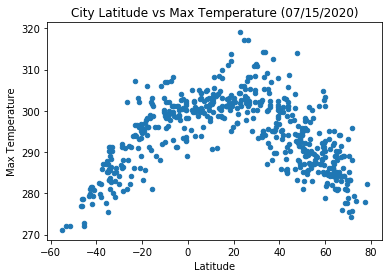

In [35]:
clean_data.plot.scatter("lat", "max_temp", title="City Latitude vs Max Temperature (07/15/2020)")
plt.ylabel("Max Temperature")
plt.xlabel("Latitude");


## Latitude vs. Humidity Plot

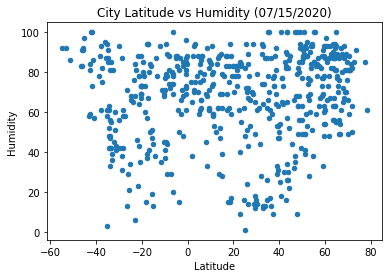

In [33]:
clean_data.plot.scatter("lat", "humidity", title="City Latitude vs Humidity (07/15/2020)")
plt.ylabel("Humidity")
plt.xlabel("Latitude");

## Latitude vs. Cloudiness Plot

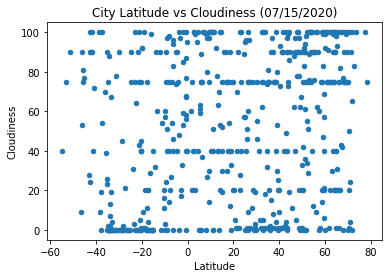

In [32]:
clean_data.plot.scatter("lat", "cloudiness", title="City Latitude vs Cloudiness (07/15/2020)")
plt.ylabel("Cloudiness")
plt.xlabel("Latitude");

## Latitude vs. Wind Speed Plot

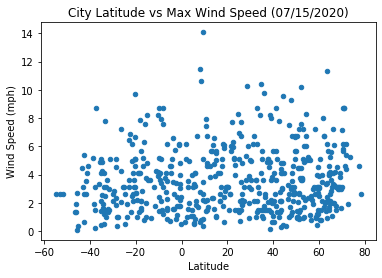

In [31]:
clean_data.plot.scatter("lat", "wind_speed", title="City Latitude vs Max Wind Speed (07/15/2020)")
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude");

## Linear Regression

In [41]:
# OPTIONAL: Create a function to create Linear Regression plots


def plot_linear_regression(df, var, target, title, xlabel, ylabel):
    m,b,_,_,_ = linregress(df[var], df[target])


    fig,ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(df[var].values, df[var].values*m + b, "m")
    df.plot.scatter(var, target, ax=ax, c="c")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()     

In [44]:
# Create Northern and Southern Hemisphere DataFrames
northern = clean_data[clean_data.lat >=0]
southern = clean_data[clean_data.lat <0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

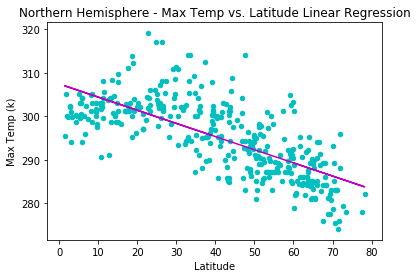

In [45]:
plot_linear_regression(northern, "lat", "max_temp", "Northern Hemisphere - Max Temp vs. Latitude Linear Regression", "Latitude", "Max Temp (k)")


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

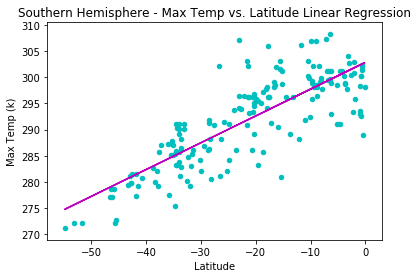

In [46]:
plot_linear_regression(southern, "lat", "max_temp", "Southern Hemisphere - Max Temp vs. Latitude Linear Regression", "Latitude", "Max Temp (k)")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

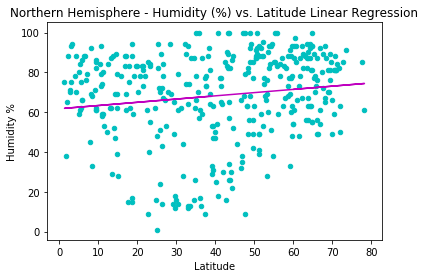

In [47]:
plot_linear_regression(northern, "lat", "humidity", "Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression", "Latitude", "Humidity %")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

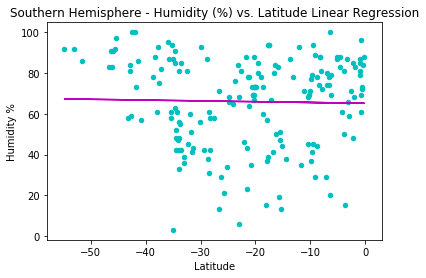

In [48]:
plot_linear_regression(southern, "lat", "humidity", "Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression", "Latitude", "Humidity %")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

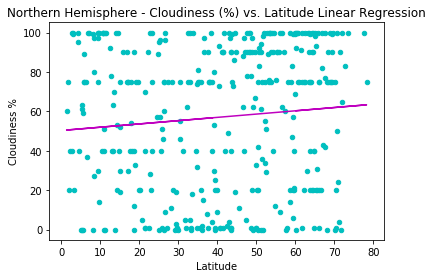

In [50]:
plot_linear_regression(northern, "lat", "cloudiness", "Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression", "Latitude", "Cloudiness %")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

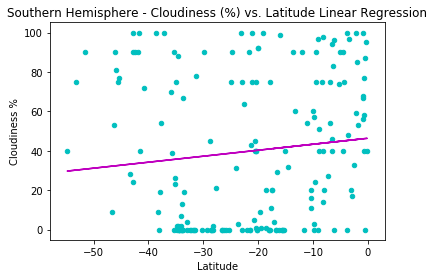

In [51]:
plot_linear_regression(southern, "lat", "cloudiness", "Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression", "Latitude", "Cloudiness %")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

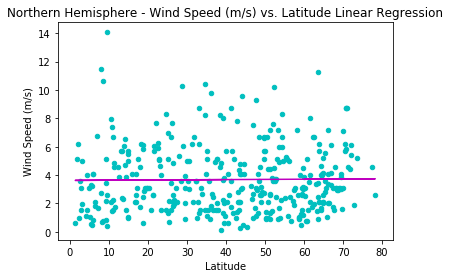

In [53]:
plot_linear_regression(northern, "lat", "wind_speed", "Northern Hemisphere - Wind Speed (m/s) vs. Latitude Linear Regression", "Latitude", "Wind Speed (m/s)")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

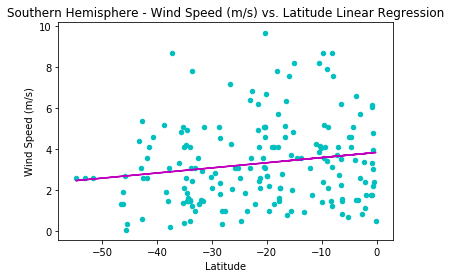

In [54]:
plot_linear_regression(southern, "lat", "wind_speed", "Southern Hemisphere - Wind Speed (m/s) vs. Latitude Linear Regression", "Latitude", "Wind Speed (m/s)")